In [ ]:
import torch

In [476]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests

import scipy.stats as si

import datetime
from tqdm import tqdm


In [477]:
!pip install gql
!pip install requests_toolbelt

In [478]:
import plotly.express as px

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [479]:
def run_query(query: str) -> list:
    sample_transport = RequestsHTTPTransport(
        url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3',
        verify=True,
        retries=3
    )
    client = Client(transport=sample_transport)
    query_doc: Document = gql(query)
    return client.execute(query_doc)

In [480]:
def uniswap_v3_pandas(list_of_dicts: list) -> None:
    pairs = []
    for i in response['poolDayDatas']:
        pairs.append(
            [
                i['date'],
                i['volumeUSD'],
                i['token0Price']
            ])

    df = pd.DataFrame(pairs)
    pd.set_option('display.max_rows',None)
    pd.set_option('display.max_colwidth', 18)
#     df[2] = df[2].astype(float)
#     df[2] = df[2].apply(lambda x: "${:,.2f}".format((x)))
    df.columns = ['date', 'volumeUSD', 'token0Price']
#     df['Pair'] = df['Token1'] + '-' + df['Token2']
    return df

In [481]:
query_str = '''
query
{
    poolDayDatas(skip: 1, first: 500, orderBy: date, orderDirection: desc, where:{pool: "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"}) {
	    date  
  	  volumeUSD
        token0Price
    	
    }
}
'''
response = run_query(query_str)
uniswap_data = uniswap_v3_pandas(response)

In [482]:
uniswap_data['token0Price'] = (uniswap_data['token0Price'].apply(lambda x: float(x)))
uniswap_data['volumeUSD'] = (uniswap_data['volumeUSD'].apply(lambda x: float(x)))
# uniswap_data['feesUSD'] = (uniswap_data['feesUSD'].apply(lambda x: float(x)))


In [483]:
uniswap_data.describe()

,date,volumeUSD,token0Price
count,5.000000e+02,5.000000e+02,500.000000
mean,1.646568e+09,9.930041e+07,2611.083980
std,1.248323e+07,7.026917e+07,1018.348003
min,1.625011e+09,7.675899e+06,995.108800
25%,1.635790e+09,5.691222e+07,1633.479111
50%,1.646568e+09,8.299055e+07,2653.652879
75%,1.657346e+09,1.194635e+08,3321.415330
max,1.668125e+09,5.429405e+08,4806.142368


In [484]:
uniswap_data.head()

,date,volumeUSD,token0Price
0,1668124800,1.874770e+08,1287.585338
1,1668038400,2.500611e+08,1296.428681
2,1667952000,3.687432e+08,1098.458691
3,1667865600,3.026654e+08,1333.692428
4,1667779200,4.252944e+07,1565.069802


In [485]:
uniswap_data['token0Price'] = uniswap_data['token0Price'].apply(lambda x: (x - uniswap_data['token0Price'].mean())/uniswap_data['token0Price'].std())

uniswap_data['volumeUSD'] = uniswap_data['volumeUSD'].apply(lambda x: (x - uniswap_data['volumeUSD'].mean())/uniswap_data['volumeUSD'].std())



Text(0.5, 0.98, 'Eth price and Uniswap eth-usdc volume')

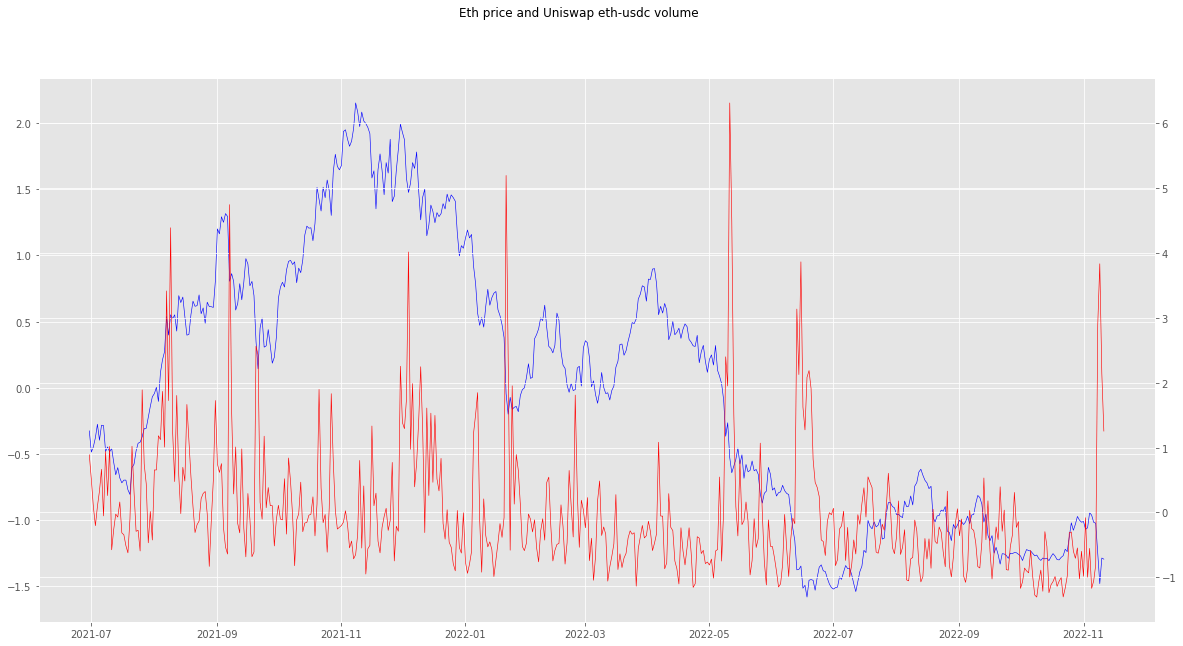

In [486]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))


ax.plot(pd.to_datetime(uniswap_data['date'],unit='s'), uniswap_data['token0Price'], 'b')

ax2 = ax.twinx()

ax2.plot(pd.to_datetime(uniswap_data['date'],unit='s'), uniswap_data['volumeUSD'], 'r')

# ax.legend(['eth price', 'volume usd'])

fig.suptitle('Eth price and Uniswap eth-usdc volume')

In [487]:
uniswap_data['price_diff'] = uniswap_data['token0Price'].diff()

Text(0.5, 0.98, 'Uniswap eth-usdc volume vs eth price deltas (price[t+1]-price[t])')

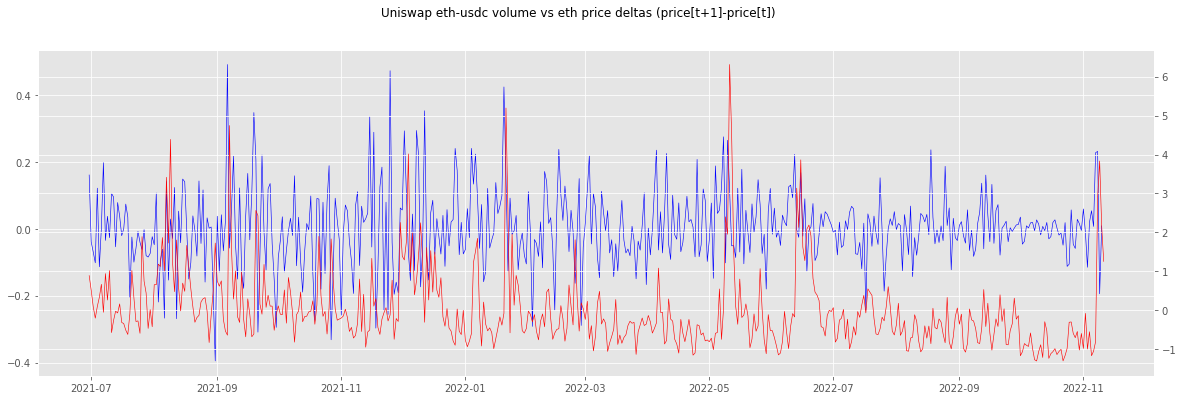

In [488]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))


ax.plot(pd.to_datetime(uniswap_data['date'],unit='s'), uniswap_data['price_diff'], 'b')

ax2 = ax.twinx()

ax2.plot(pd.to_datetime(uniswap_data['date'],unit='s'), uniswap_data['volumeUSD'], 'r')

fig.suptitle('Uniswap eth-usdc volume vs eth price deltas (price[t+1]-price[t])')

In [489]:
uniswap_data.corr()

,date,volumeUSD,token0Price,price_diff
date,1.000000,-0.286744,-0.697932,0.049045
volumeUSD,-0.286744,1.000000,0.130136,-0.061134
token0Price,-0.697932,0.130136,1.000000,0.044039
price_diff,0.049045,-0.061134,0.044039,1.000000


In [490]:
def BSM_Price(S, K, T, r, sigma, putcall):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if putcall == 'C':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif putcall == 'P':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    return result

def BSM_IV(S, K, T, r, price, putcall):
    thisIV = 1
    dIV = 0.01
    thresholdPx = 0.001
    for i in range(20):
        thisPx = BSM_Price(S, K, T, r, thisIV, putcall)
        dPx = BSM_Price(S, K, T, r, thisIV + dIV, putcall) - thisPx
        thisIV = thisIV + (price - thisPx) / dPx * dIV
        if dPx <= thresholdPx:
            break
    return thisIV

In [491]:
def DateStrToInt(dateStr):
    return (datetime.datetime.strptime(dateStr + 'UTC08', '%d%b%y%Z%H') - datetime.datetime.utcnow()).total_seconds() / 86400

def GetOptionBook():
    urlOptionBook = "https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency=BTC&kind=option"
    jsonOptionBook = requests.get(url = urlOptionBook).json() 
    resultOptionBook = jsonOptionBook['result']
    for i in resultOptionBook:
        instrument_name = i['instrument_name']
        instrument_data = instrument_name.split("-")
        underlying = instrument_data[0]
        expiry = instrument_data[1]
        strike = float(instrument_data[2])
        putcall = instrument_data[3]
        TTM = DateStrToInt(expiry)/365.25
        underlying_price = float(i['underlying_price'])
        bid_price = i['bid_price']
        ask_price = i['ask_price']
        mid_price = i['mid_price']

        if bid_price==None:
            i['bid_IV'] = None
        else:
            i['bid_IV'] = BSM_IV(underlying_price,strike,TTM,0,float(bid_price)*underlying_price,putcall)

        if ask_price==None:
            i['ask_IV'] = None
        else:
            i['ask_IV'] = BSM_IV(underlying_price,strike,TTM,0,float(ask_price)*underlying_price,putcall)

        if mid_price==None:
            i['mid_IV'] = None
        else:
            i['mid_IV'] = BSM_IV(underlying_price,strike,TTM,0,float(mid_price)*underlying_price,putcall)
        #print(i['mid_IV'] )

    return resultOptionBook
    #print([i['instrument_name'] for i in resultOptionBook])

def GetOptionMeta():
    urlOptionBook = "https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency=BTC&kind=option"
    jsonOptionBook = requests.get(url = urlOptionBook).json() 
    resultOptionBook = jsonOptionBook['result']
    dictMeta = {'Strike':[],'Expiry':[]}
    for i in resultOptionBook:

        instrument_name = i['instrument_name']
        instrument_data = instrument_name.split("-")
        expiry = instrument_data[1]
        strike = float(instrument_data[2])
        if not strike in dictMeta['Strike']:
            dictMeta['Strike'].append(strike)
        if not expiry in dictMeta['Expiry']:
            dictMeta['Expiry'].append(expiry)
        if not strike in dictMeta:
            dictMeta[strike]=[]
        if not expiry in dictMeta:
            dictMeta[expiry]=[]
        if not strike in dictMeta[expiry]:
            dictMeta[expiry].append(strike)
        if not expiry in dictMeta[strike]:
            dictMeta[strike].append(expiry)
        dictMeta['Strike'].sort()
    return dictMeta

OptionMeta = GetOptionMeta()
OptionBook = GetOptionBook()

# thisExpiry = "25NOV22"

# thisStrikes = [thisExpiry+"-"+str(int(i)) for i in sorted(OptionMeta[thisExpiry])]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

divide by zero encountered in double_scalars



In [492]:
# OptionMeta

In [493]:
# EXPIRIES = ['13NOV22', '18NOV22', '25NOV22', '30DEC22', '27JAN23', '31MAR23', '30JUN23', '29SEP23']
# DAYS_TO_EXPIRATION = [1, 7, 14, 49, 77, 140, 231, 322]

DAYS_TO_EXPIRATION = {'14NOV22': 2, '18NOV22': 5, '25NOV22':12, '30DEC22':47, '27JAN23':75, '31MAR23':138, '30JUN23':229, '29SEP23':320}

EXPIRIES  = list(DAYS_TO_EXPIRATION.keys())


In [494]:

col_names = ['full name', 'type','expiry', 'strike', 'bid price', 'bid IV', 'ask price', 'ask IV', 'mid price', 'mid IV', 'underlying_price']

options_data = pd.DataFrame([], columns=col_names)

for thisExpiry in tqdm(EXPIRIES):
    fullNames = ["BTC-"+thisExpiry+"-"+str(int(i)) for i in sorted(OptionMeta[thisExpiry])]
    strikes = [str(int(i)) for i in sorted(OptionMeta[thisExpiry])]

    for i in (range(len(fullNames))):
#         print(fullNames[i])
        thisPut = [item for item in OptionBook if item.get('instrument_name')==fullNames[i]+"-P"][0]
#         print(thisPut)
        thisCall = [item for item in OptionBook if item.get('instrument_name')==fullNames[i]+"-C"][0]
#         print([fullNames[i], thisExpiry, strikes[i], thisPut['bid_IV'], thisCall['bid_IV'], thisPut['ask_IV'], thisCall['ask_IV']])
        row1 = pd.DataFrame([[fullNames[i], 'put',thisExpiry, strikes[i], thisPut['bid_price'], thisPut['bid_IV'], thisPut['ask_price'], thisPut['ask_IV'], thisPut['mid_price'], thisPut['mid_IV'], thisPut['underlying_price']]], columns=col_names)
        row2 = pd.DataFrame([[fullNames[i], 'call', thisExpiry, strikes[i], thisCall['bid_price'], thisCall['bid_IV'], thisCall['ask_price'], thisCall['ask_IV'], thisCall['mid_price'], thisCall['mid_IV'], thisCall['underlying_price']]], columns=col_names)

        options_data = pd.concat([options_data, row1], ignore_index=True)
        options_data = pd.concat([options_data, row2], ignore_index=True)



100%|██████████| 8/8 [00:00<00:00,  9.40it/s]


In [495]:
options_data.head()

,full name,type,expiry,strike,bid price,bid IV,ask price,ask IV,mid price,mid IV,underlying_price
0,BTC-14NOV22-13000,put,14NOV22,13000,NaN,NaN,0.0005,1.782089,NaN,NaN,16813.712702
1,BTC-14NOV22-13000,call,14NOV22,13000,NaN,NaN,NaN,NaN,NaN,NaN,16813.712702
2,BTC-14NOV22-14000,put,14NOV22,14000,0.0005,1.324256,0.001,1.476963,0.00075,1.408767,16813.712702
3,BTC-14NOV22-14000,call,14NOV22,14000,NaN,NaN,NaN,NaN,NaN,NaN,16813.712702
4,BTC-14NOV22-14500,put,14NOV22,14500,0.001,1.234998,0.0015,1.331747,0.00125,1.28618,16813.712702


In [496]:
DAYS_IN_YEAR = 365.25

options_data['expiry in years'] = options_data['expiry'].apply(lambda x: DAYS_TO_EXPIRATION[x] / DAYS_IN_YEAR )

In [497]:
options_data.head()

,full name,type,expiry,strike,bid price,bid IV,ask price,ask IV,mid price,mid IV,underlying_price,expiry in years
0,BTC-14NOV22-13000,put,14NOV22,13000,NaN,NaN,0.0005,1.782089,NaN,NaN,16813.712702,0.005476
1,BTC-14NOV22-13000,call,14NOV22,13000,NaN,NaN,NaN,NaN,NaN,NaN,16813.712702,0.005476
2,BTC-14NOV22-14000,put,14NOV22,14000,0.0005,1.324256,0.001,1.476963,0.00075,1.408767,16813.712702,0.005476
3,BTC-14NOV22-14000,call,14NOV22,14000,NaN,NaN,NaN,NaN,NaN,NaN,16813.712702,0.005476
4,BTC-14NOV22-14500,put,14NOV22,14500,0.001,1.234998,0.0015,1.331747,0.00125,1.28618,16813.712702,0.005476


In [498]:
# pd.to_datetime(options_data['expiry'], format='%dd%mm%yy')


In [499]:
options_data_on_day = options_data[(options_data['expiry']) == '30DEC22']


In [500]:
options_data_on_day.replace(to_replace=[None], value=np.nan, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [501]:
options_data_on_day['strike'] = options_data_on_day['strike'].apply(lambda x: float(x))

options_data_on_day['bid IV'] = options_data_on_day['bid IV'].apply(lambda x: float(x))
options_data_on_day['ask IV'] = options_data_on_day['ask IV'].apply(lambda x: float(x))




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [502]:
options_data_on_day.dtypes

full name            object
type                 object
expiry               object
strike              float64
bid price           float64
bid IV              float64
ask price           float64
ask IV              float64
mid price           float64
mid IV              float64
underlying_price    float64
expiry in years     float64
dtype: object

In [503]:
options_data_on_day = options_data_on_day.drop(options_data_on_day[abs(options_data_on_day['bid IV']) > 10].index).dropna()

options_data_on_day = options_data_on_day.drop(options_data_on_day[abs(options_data_on_day['ask IV']) > 10].index).dropna()



In [504]:
puts = options_data_on_day[options_data_on_day['type']=='put'][['full name', 'expiry', 'strike', 'bid IV', 'ask IV']].dropna()
calls = options_data_on_day[options_data_on_day['type']=='call'][['full name', 'expiry', 'strike', 'bid IV', 'ask IV']].dropna()

In [505]:
puts = puts.drop(puts[abs(puts['bid IV']) > 10].index)
puts = puts.drop(puts[abs(puts['ask IV']) > 10].index)

calls = calls.drop(calls[abs(calls['bid IV']) > 10].index)

calls = calls.drop(calls[abs(calls['ask IV']) > 10].index)


In [506]:
# options_data_on_day

Text(0.5, 0.98, 'PUTS')

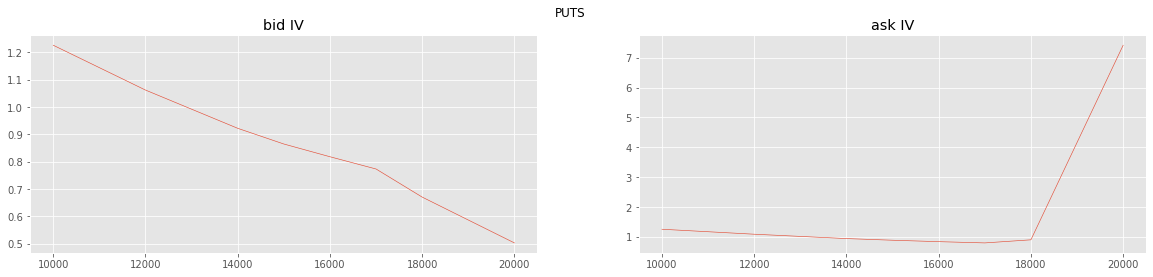

In [507]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(4)

axs[0].plot(puts['strike'], puts['bid IV'])
axs[0].set_title('bid IV')

axs[1].plot(puts['strike'], puts['ask IV'])
axs[1].set_title('ask IV')

fig.suptitle('PUTS')

Text(0.5, 0.98, 'CALLS')

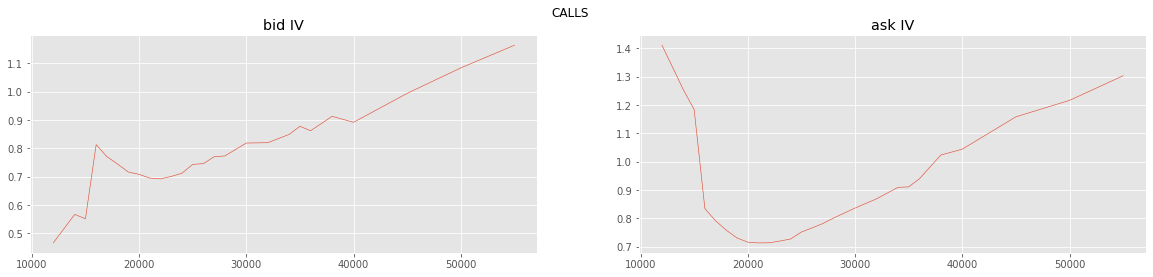

In [508]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(4)

axs[0].plot(calls['strike'], calls['bid IV'])
axs[0].set_title('bid IV')

axs[1].plot(calls['strike'], calls['ask IV'])
axs[1].set_title('ask IV')

fig.suptitle('CALLS')

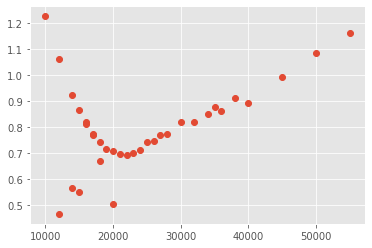

In [509]:
# # fig, axs = plt.subplots(ncols=2)
# fig.set_figwidth(20)
# fig.set_figheight(4)

plt.plot(options_data_on_day['strike'], options_data_on_day['bid IV'], 'o')
# axs[0].set_title('bid IV')

# axs[1].plot(options_data_on_day['strike'], options_data_on_day['ask IV'])
# axs[1].set_title('ask IV')



In [510]:
options_data_on_day.head(15)

,full name,type,expiry,strike,bid price,bid IV,ask price,ask IV,mid price,mid IV,underlying_price,expiry in years
172,BTC-30DEC22-10000,put,30DEC22,10000.0,0.0205,1.225876,0.0220,1.252545,0.02125,1.239301,16705.47,0.128679
174,BTC-30DEC22-12000,put,30DEC22,12000.0,0.0345,1.062014,0.0365,1.086055,0.03550,1.074081,16705.47,0.128679
175,BTC-30DEC22-12000,call,30DEC22,12000.0,0.2830,0.466587,0.3475,1.410202,0.31525,1.050796,16705.47,0.128679
176,BTC-30DEC22-14000,put,30DEC22,14000.0,0.0570,0.922181,0.0590,0.939853,0.05800,0.931027,16705.47,0.128679
177,BTC-30DEC22-14000,call,30DEC22,14000.0,0.1820,0.567085,0.2575,1.252959,0.21975,0.929272,16705.39,0.128679
178,BTC-30DEC22-15000,put,30DEC22,15000.0,0.0735,0.864782,0.0760,0.884449,0.07475,0.874621,16705.47,0.128679
179,BTC-30DEC22-15000,call,30DEC22,15000.0,0.1370,0.551746,0.2165,1.183410,0.17675,0.873909,16705.47,0.128679
180,BTC-30DEC22-16000,put,30DEC22,16000.0,0.0950,0.818233,0.0975,0.836363,0.09625,0.827298,16705.47,0.128679
181,BTC-30DEC22-16000,call,30DEC22,16000.0,0.1365,0.812939,0.1395,0.834695,0.13800,0.823817,16705.47,0.128679
182,BTC-30DEC22-17000,put,30DEC22,17000.0,0.1210,0.773391,0.1240,0.794294,0.12250,0.783841,16705.47,0.128679


In [511]:
puts['bid IV'] = puts['bid IV'].apply(lambda x: float(x))
calls['bid IV'] = calls['bid IV'].apply(lambda x: float(x))


---

In [512]:
options_data = options_data.dropna()
options_data = options_data.drop(options_data[abs(options_data['bid IV']) > 2.7].index)
options_data = options_data.drop(options_data[abs(options_data['ask IV']) > 2.7].index)
options_data = options_data.drop(options_data[abs(options_data['mid IV']) > 2.7].index)




options_data['bid IV'] = options_data['bid IV'].apply(lambda x: float(x))
options_data['ask IV'] = options_data['ask IV'].apply(lambda x: float(x))
options_data['mid IV'] = options_data['mid IV'].apply(lambda x: float(x))

options_data['bid price'] = options_data['bid price'].apply(lambda x: float(x))
options_data['ask price'] = options_data['ask price'].apply(lambda x: float(x))
options_data['mid price'] = options_data['mid price'].apply(lambda x: float(x))


options_data['strike'] = options_data['strike'].apply(lambda x: float(x))
options_data['underlying_price'] = options_data['underlying_price'].apply(lambda x: float(x))

In [513]:
options_data.dtypes

full name            object
type                 object
expiry               object
strike              float64
bid price           float64
bid IV              float64
ask price           float64
ask IV              float64
mid price           float64
mid IV              float64
underlying_price    float64
expiry in years     float64
dtype: object

In [514]:
options_data.head()

,full name,type,expiry,strike,bid price,bid IV,ask price,ask IV,mid price,mid IV,underlying_price,expiry in years
2,BTC-14NOV22-14000,put,14NOV22,14000.0,0.0005,1.324256,0.0010,1.476963,0.00075,1.408767,16813.712702,0.005476
4,BTC-14NOV22-14500,put,14NOV22,14500.0,0.0010,1.234998,0.0015,1.331747,0.00125,1.286180,16813.712702,0.005476
6,BTC-14NOV22-15000,put,14NOV22,15000.0,0.0015,1.078189,0.0020,1.147030,0.00175,1.113910,16813.712702,0.005476
8,BTC-14NOV22-15500,put,14NOV22,15500.0,0.0030,0.978337,0.0035,1.021343,0.00325,1.000196,16813.712702,0.005476
10,BTC-14NOV22-15750,put,14NOV22,15750.0,0.0040,0.909931,0.0050,0.978904,0.00450,0.945118,16813.712702,0.005476


# Turning price expressed in btc into usd

In [515]:
options_data['bid price'] = options_data['bid price']*options_data['underlying_price']
options_data['ask price'] = options_data['ask price']*options_data['underlying_price']
options_data['mid price'] = options_data['mid price']*options_data['underlying_price']

In [516]:
options_data.head()

,full name,type,expiry,strike,bid price,bid IV,ask price,ask IV,mid price,mid IV,underlying_price,expiry in years
2,BTC-14NOV22-14000,put,14NOV22,14000.0,8.406856,1.324256,16.813713,1.476963,12.610285,1.408767,16813.712702,0.005476
4,BTC-14NOV22-14500,put,14NOV22,14500.0,16.813713,1.234998,25.220569,1.331747,21.017141,1.286180,16813.712702,0.005476
6,BTC-14NOV22-15000,put,14NOV22,15000.0,25.220569,1.078189,33.627425,1.147030,29.423997,1.113910,16813.712702,0.005476
8,BTC-14NOV22-15500,put,14NOV22,15500.0,50.441138,0.978337,58.847994,1.021343,54.644566,1.000196,16813.712702,0.005476
10,BTC-14NOV22-15750,put,14NOV22,15750.0,67.254851,0.909931,84.068564,0.978904,75.661707,0.945118,16813.712702,0.005476


In [517]:
# pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

In [518]:
# _options_data

In [519]:
import plotly.express as px

_options_data = options_data[options_data['type']=='put'][['strike', 'expiry in years','mid IV']] 

fig = px.scatter_3d(_options_data, x='strike', y='expiry in years', z='mid IV',)

fig.update_layout(
    title_text='Deribit Vol surface (mid imp vols)')

fig.show()

# Heston model

In [520]:
!pip install eod && pip install nelson_siegel_svensson

In [521]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize 
from datetime import datetime as dt
from eod import EodHistoricalData
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [522]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    
    # constants
    a = kappa*theta
    b = kappa+lambd
    
    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )
    
    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)
    
    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
    return exp1*term2*exp2

In [523]:
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

In [524]:
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width
    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)
        
        P += dphi * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [525]:
def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    real_integral, err = np.real( quad(integrand, 0, 100, args=args) )
    
    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [526]:
# Parameters to test model
S0 = 16700. # initial asset price
K = 17000. # strike
v0 = 0.1 # initial variance
r = 0.00 # risk free rate
kappa = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
sigma = 0.3 # volatility of volatility
lambd = 0.575 # risk premium of variance
rho = -0.5711 # correlation between variance and stock process
tau = 0.019165 # time to maturity
heston_price( S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r )

/opt/conda/lib/python3.7/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning:

Casting complex values to real discards the imaginary part



163.9576029677949

In [527]:
yield_maturities = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array([0.15,0.27,0.50,0.93,1.52,2.13,2.32,2.34,2.37,2.32,2.65,2.52]).astype(float)/100

In [528]:
#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yeilds) 

curve_fit

NelsonSiegelSvenssonCurve(beta0=0.0283915324040199, beta1=-0.02927949906579232, beta2=0.025428223300783523, beta3=-0.014174075594580287, tau1=0.9922984535738066, tau2=4.781409405996536)

In [529]:
curve_fit(yield_maturities[4])

0.01539185676472801

In [530]:
# options_data = options_data[(options_data['type'] == 'call') & (options_data['expiry'] == '30DEC22')]
options_data = options_data[(options_data['type'] == 'call')]

In [531]:
options_data.head(30)

,full name,type,expiry,strike,bid price,bid IV,ask price,ask IV,mid price,mid IV,underlying_price,expiry in years
15,BTC-14NOV22-16250,call,14NOV22,16250.0,664.141652,0.699014,765.023928,0.982913,714.582790,0.845626,16813.712702,0.005476
17,BTC-14NOV22-16500,call,14NOV22,16500.0,470.783956,0.658799,538.038806,0.825336,504.411381,0.742772,16813.712702,0.005476
19,BTC-14NOV22-16750,call,14NOV22,16750.0,319.460541,0.652524,344.681110,0.710189,332.070826,0.681361,16813.712702,0.005476
21,BTC-14NOV22-17000,call,14NOV22,17000.0,184.950840,0.605582,210.171409,0.664647,197.561124,0.635162,16813.712702,0.005476
23,BTC-14NOV22-17250,call,14NOV22,17250.0,100.882276,0.591521,117.695989,0.637722,109.289133,0.614797,16813.712702,0.005476
25,BTC-14NOV22-17500,call,14NOV22,17500.0,50.441138,0.584774,67.254851,0.646069,58.847994,0.616171,16813.712702,0.005476
27,BTC-14NOV22-18000,call,14NOV22,18000.0,16.813713,0.646453,25.220569,0.706640,21.017141,0.678122,16813.712702,0.005476
47,BTC-18NOV22-16000,call,18NOV22,16000.0,1086.992400,0.823968,1187.330160,0.959176,1137.161280,0.891979,16722.960000,0.013689
49,BTC-18NOV22-16500,call,18NOV22,16500.0,769.252480,0.796675,802.698240,0.837957,785.975360,0.817320,16722.880000,0.013689
51,BTC-18NOV22-17000,call,18NOV22,17000.0,493.324960,0.749107,518.409280,0.779798,505.867120,0.764457,16722.880000,0.013689


# Calibration

In [532]:
# Define variables to be used in optimization
S0 = options_data.iloc[1,:]['underlying_price']
r = np.array([0 for _ in range(len(options_data))])
K = options_data['strike'].to_numpy('float')
tau = options_data['expiry in years'].to_numpy('float')
P = options_data['mid price'].to_numpy('float')

# 0.5366793895598745 3.1912746886232486 0.4820203973384749 0.3476223038042814 0.17909367313309923 0.08887178290000734
# err: 18231.598507533607 pen: 7712.324495591222



params = {"v0": {"x0": 0.5366793895598745, "lbub": [1e-3,5]}, 
          "kappa": {"x0": 3.1912746886232486, "lbub": [-5,5]},
          "theta": {"x0": 0.4820203973384749, "lbub": [-2,2]},
          "sigma": {"x0": 0.3476223038042814, "lbub": [-2,2]},
          "rho": {"x0": 0.17909367313309923, "lbub": [-1,1]},
          "lambd": {"x0": 0.08887178290000734, "lbub": [-1,1]},
          }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

In [533]:
v0, kappa, theta, sigma, rho, lambd = [param["x0"] for key, param in params.items()]

In [534]:
# print(K)
# print(tau)
# print(P)

In [535]:
# This is the calibration function
# heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
# Parameters are v0, kappa, theta, sigma, rho, lambd

def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]
    
    # Attempted to use scipy integrate quad module as constrained to single floats not arrays
    # err = np.sum([ (P_i-heston_price(S0, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i))**2 /len(P) \
    #               for P_i, K_i, tau_i, r_i in zip(marketPrices, K, tau, r)])
    
    print(v0, kappa, theta, sigma, rho, lambd)
#     print(P)

    # Decided to use rectangular integration function in the end
    _heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
    err = np.sum( (P - _heston_prices)**2 / len(P) )
    
    
    # Zero penalty term - no good guesses for parameters
    pen = 0 #np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )
    
    _pens =  _heston_prices[_heston_prices < 0 ]
    
    pen = abs(np.sum(_pens))**1.5 /  len(_pens)
    
    print('err:', err, 'pen:', pen)

          
    return err + pen


In [536]:
# S0, K, 100.5, 1.1, 5, 0.2, 0.8, 0.0, tau, 0.0

In [537]:
# np.array([S0 for _ in range(len(options_data))])

In [538]:
# _heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)

# _heston_prices = _heston_prices[_heston_prices < 0]
# _heston_prices

In [539]:
# options_data.head()

In [540]:

# result = minimize(SqErr, x0, tol = 1e-3, method='L-BFGS-B', options={'maxiter': 1e4,'disp': True } )

# v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
# v0, kappa, theta, sigma, rho, lambd

In [541]:
# L-BFGS-B

# loss: 8560

# 0.6376918895879328 1.0126195811465042 0.08991197867415827 0.3116289075019272 -0.8046427648739165 0.041801958583274804


In [542]:
v0, kappa, theta, sigma, rho, lambd

(0.5366793895598745,
 3.1912746886232486,
 0.4820203973384749,
 0.3476223038042814,
 0.17909367313309923,
 0.08887178290000734)

In [543]:
heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
options_data['heston_price'] = heston_prices

In [553]:
options_data.head(25)

,full name,type,expiry,strike,bid price,bid IV,ask price,ask IV,mid price,mid IV,underlying_price,expiry in years,heston_price
15,BTC-14NOV22-16250,call,14NOV22,16250.0,664.141652,0.699014,765.023928,0.982913,714.582790,0.845626,16813.712702,0.005476,707.138987
17,BTC-14NOV22-16500,call,14NOV22,16500.0,470.783956,0.658799,538.038806,0.825336,504.411381,0.742772,16813.712702,0.005476,538.009459
19,BTC-14NOV22-16750,call,14NOV22,16750.0,319.460541,0.652524,344.681110,0.710189,332.070826,0.681361,16813.712702,0.005476,395.231097
21,BTC-14NOV22-17000,call,14NOV22,17000.0,184.950840,0.605582,210.171409,0.664647,197.561124,0.635162,16813.712702,0.005476,279.718306
23,BTC-14NOV22-17250,call,14NOV22,17250.0,100.882276,0.591521,117.695989,0.637722,109.289133,0.614797,16813.712702,0.005476,190.377103
25,BTC-14NOV22-17500,call,14NOV22,17500.0,50.441138,0.584774,67.254851,0.646069,58.847994,0.616171,16813.712702,0.005476,124.419539
27,BTC-14NOV22-18000,call,14NOV22,18000.0,16.813713,0.646453,25.220569,0.706640,21.017141,0.678122,16813.712702,0.005476,46.768730
47,BTC-18NOV22-16000,call,18NOV22,16000.0,1086.992400,0.823968,1187.330160,0.959176,1137.161280,0.891979,16722.960000,0.013689,1057.186099
49,BTC-18NOV22-16500,call,18NOV22,16500.0,769.252480,0.796675,802.698240,0.837957,785.975360,0.817320,16722.880000,0.013689,738.449072
51,BTC-18NOV22-17000,call,18NOV22,17000.0,493.324960,0.749107,518.409280,0.779798,505.867120,0.764457,16722.880000,0.013689,488.538585


In [555]:
import plotly.graph_objects as go
from plotly.graph_objs import Surface
from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode()

fig = go.Figure(data=[go.Mesh3d(x=options_data['expiry in years'], y=options_data.strike, z=options_data['heston_price'], color='mediumblue', opacity=0.55),
                     go.Mesh3d(x=options_data['expiry in years'], y=options_data.strike, z=options_data['mid price'], opacity=0.55)])

# fig.add_scatter3d(x=options_data['expiry in years'], y=options_data.strike, z=options_data['mid price'])

fig.update_layout(
    title_text='Market Prices (Mesh) vs Calibrated Heston Prices (Markers)',
    scene = dict(xaxis_title='TIME (Years)',
                    yaxis_title='STRIKES',
                    zaxis_title='INDEX OPTION PRICE (Pts)'),
    height=800,
    width=800
)

fig.show()

# Heston model simulations

In [546]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=paths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    
    if return_vol:
        return prices, sigs
    
    return prices

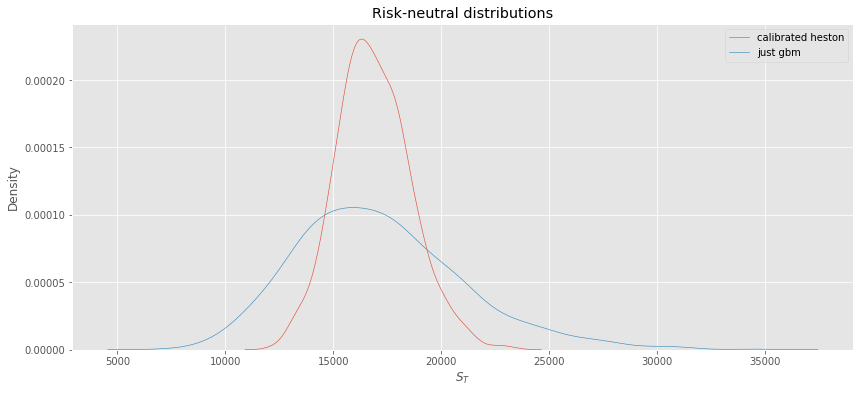

In [551]:
v0, kappa, theta, sigma, rho, lambd = [param["x0"] for key, param in params.items()]

xi = sigma
r = 0
S = options_data.iloc[1, :]['underlying_price']
paths = 1000
steps = 1000
T = 0.1

risk_neutral_distr = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=rho, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]  
      
gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T , 
                                np.sqrt(theta)*np.sqrt(T), size=paths))

import seaborn as sns

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(6)


ax = sns.kdeplot(data=risk_neutral_distr, label=r"$\rho = 0.9$", ax=ax)
ax = sns.kdeplot(data=gbm_bench, label="GBM", ax=ax)

ax.set_title(r'Risk-neutral distributions')
# plt.axis([40, 180, 0, 0.055])
plt.xlabel('$S_T$')
plt.ylabel('Density')

plt.legend(['calibrated heston', 'just gbm'])

In [548]:
# options_data.iloc[1, :]

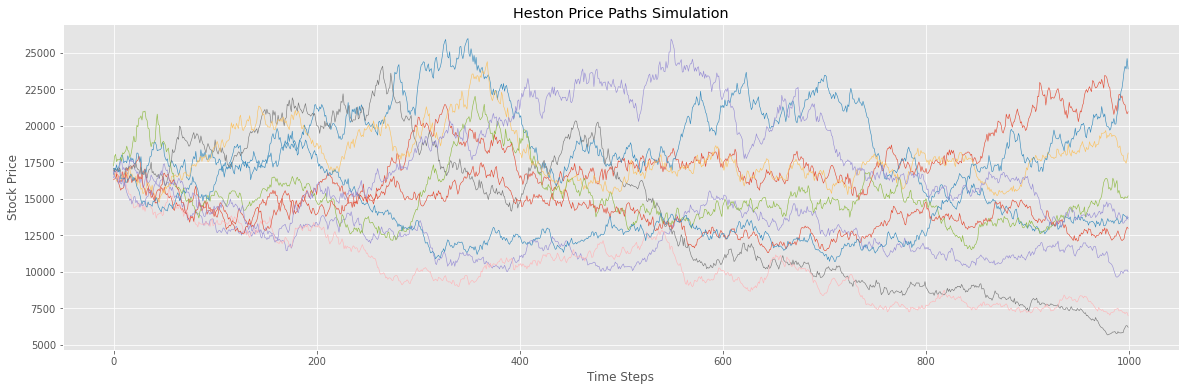

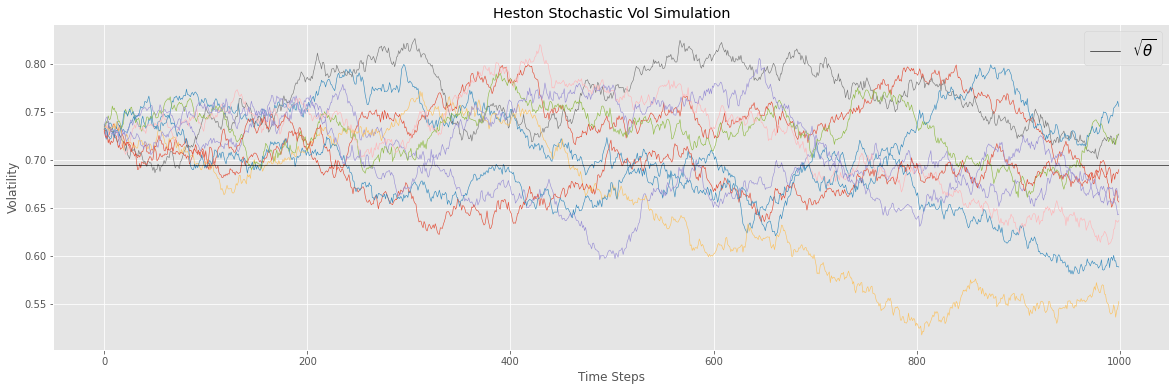

In [549]:
v0, kappa, theta, sigma, rho, lambd = [param["x0"] for key, param in params.items()]

xi = sigma
r = 0
S = options_data.iloc[1, :]['underlying_price']
paths = 10
steps = 1000
T = 0.5

prices,sigs = generate_heston_paths(S, T, r, kappa, theta,
                                    v0, rho, xi, steps, paths,
                                    return_vol=True)        
    
plt.figure(figsize=(20,6))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(20,6))
plt.plot(np.sqrt(sigs).T)
plt.axhline(np.sqrt(theta), color='black', label=r'$\sqrt{\theta}$')
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend(fontsize=15)
plt.show()